In [210]:
import os

In [211]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [212]:
os.chdir("../.")

In [213]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [214]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [ ]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelTrainingConfig:
    """Configuration for model training.
    """
    model_name: str
    root_dir: Path
    test_data_dir: Path
    train_data_dir: Path
    random_state: int
    class_weight: str
    n_jobs: int
    target_column: str
    label_encoder_file: str
    C: float
    penalty: str
    solver: str
    max_iter: int
    
   
    
   
    


    

In [216]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [ ]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_training_config(self) -> ModelTrainingConfig:
        config = self.config.model_training
        params = self.params.logistic_regression
        schema =  self.schema.target_column

        create_directories([self.config.artifacts_root])

        model_training_config = ModelTrainingConfig(
            root_dir=Path(config.root_dir),
            train_data_dir = Path(config.train_data_dir),
            test_data_dir = Path(config.test_data_dir),
            model_name = config.model_name,
            random_state = params.random_state,
            class_weight = params.class_weight,
            n_jobs = params.n_jobs,
            target_column = schema.name,
            label_encoder_file = config.label_encoder_file,
            C = params.C,
            penalty = params.penalty,
            solver = params.solver, 
            max_iter = params.max_iter
            )
           
            
        

        return model_training_config

In [218]:
import pandas as pd
import os
from BankProducts import logger
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


import joblib
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer







In [219]:
class ModelTraining:
    def __init__(self, config: ModelTrainingConfig):
        self.config = config
        self.model = None

    def train(self):
        logger.info("Loading training data")
        
        os.makedirs(os.path.dirname(self.config.train_data_dir), exist_ok=True)
        # Load the training data
        
        train_data = pd.read_csv(self.config.train_data_dir)
        X_train = train_data.drop(columns=[self.config.target_column])
        #  [["customersegment", "product_category", "amount", "monthlyincome"]] 
        #X_train = X_train[['productcategory', 'amount', 'monthlyincome', 'customersegment']]
        # print the first 5 rows of the data    
        #print(X_train.head())
        # Log the shape of the data
        #logger.info(f"Transformed data shape: {X_train.shape}")
        #print(f"Transformed data shape: {X_train.shape}")
        
        y_train = train_data[self.config.target_column]
        
        # encode the target variable if it's categorical
        if y_train.dtype == 'object' or y_train.dtype.name == 'category':
            logger.info("Encoding target variable")
            label_encoder = LabelEncoder()
            y_train = label_encoder.fit_transform(y_train)
        else:
            logger.info("Target variable is already numeric, no encoding needed")   
        logger.info("Loading validation data")
        
         # Create directory if it doesn't exist
        model_dir = self.config.root_dir
        os.makedirs(model_dir, exist_ok=True)
        
       
        
        # save the label_encoder for future use
        label_encoder_path = os.path.join(model_dir , self.config.label_encoder_file)
        joblib.dump(label_encoder, label_encoder_path)
        
        logger.info("Label encoder saved to: %s", label_encoder_path)
         
        
        logger.info("Training the model")
        # Identify categorical and numerical features
        categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
        numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
      
        #preprocessor = ColumnTransformer(
            #transformers=[
                #('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
                #('num', SimpleImputer(strategy='mean'), numerical_features)
            #],
           # remainder='passthrough'  # Keep other columns as they are
        #)

        # Initialize the RandomForestClassifier with the provided configuration
        model = LogisticRegression(
            C=self.config.C,
            penalty=self.config.penalty,
            solver=self.config.solver,
            max_iter=self.config.max_iter,
            random_state=self.config.random_state,      
            class_weight=self.config.class_weight,      
            n_jobs=self.config.n_jobs
        )
        #model = RandomForestClassifier(
        
        
       # Create the pipeline combining preprocessing, scaling, and modeling
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), numerical_features)
            ],
            remainder='passthrough' 
        )

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Fit the pipeline to the training data
        
        
        print("X_TRAIN", X_train[:15])
        print("Y_train", y_train[:10])

        pipeline.fit(X_train, y_train)
        
        X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
        print("X_train after preprocessing:", X_train_transformed[:1])

        
        import numpy as np

        classifier = pipeline.named_steps['classifier']
        preprocessor = pipeline.named_steps['preprocessor']

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Get the coefficient matrix (shape: n_classes x n_features)
        coefs = classifier.coef_

        # Take the mean of absolute values across all classes (axis=0)
        importances = np.mean(np.abs(coefs), axis=0)
        
        # Sort by importance
        sorted_indices = np.argsort(importances)[::-1]

        # Limit to top N (avoid index errors)
        top_n = min(20, len(sorted_indices))

        # Display
        print("Top important features (averaged across all classes):")
        for i in sorted_indices[:top_n]:
            
            
            print(f"{feature_names[i]}: {importances[i]:.4f}")

        import matplotlib.pyplot as plt

        top_features = [feature_names[i] for i in sorted_indices[:top_n]]
        top_importance_values = [importances[i] for i in sorted_indices[:top_n]]

        plt.figure(figsize=(10, 6))
        plt.barh(top_features[::-1], top_importance_values[::-1])
        plt.title("Top Features (Avg Absolute Coefficients - Multiclass Logistic Regression)")
        plt.xlabel("Average Absolute Coefficient")
        plt.tight_layout()
        plt.show()

        classes = classifier.classes_  # e.g., array([0, 1, 2])

        for class_index, class_label in enumerate(classes):
            print(f"\nTop features for class {class_label}:")
            class_coefs = coefs[class_index]
            sorted_idx = np.argsort(np.abs(class_coefs))[::-1]
            
            for i in sorted_idx[:10]:
                print(f"{feature_names[i]}: {class_coefs[i]:.4f}")



        
            
            import matplotlib.pyplot as plt

            top_features = [feature_names[i] for i in sorted_indices[:top_n]]
            top_importances = [importances[i] for i in sorted_indices[:top_n]]

            plt.figure(figsize=(10, 6))
            plt.barh(top_features[::-1], top_importances[::-1])
            plt.title("Top Important Features (Logistic Regression Coefficients)")
            plt.xlabel("Coefficient Value")
            plt.tight_layout()
            plt.show()

            


        logger.info("Saving the trained model")
        
                
        # Create directory if it doesn't exist
        model_dir = self.config.root_dir
        os.makedirs(model_dir, exist_ok=True)
        
        print("Model directory:", model_dir)
        print("Directory exists?", os.path.exists(model_dir))
        print("Is a directory?", os.path.isdir(model_dir))

                
        model_path = os.path.join(model_dir, self.config.model_name)
        
        print("Model path:", model_path)
        # Ensure the model path is a Path object
        model_path = Path(model_path)
        
        
        

        
        print("Model will be saved to:", model_path)
        
                # Safety check: if a directory exists where the model file should go, delete it
        if os.path.isdir(model_path):
            import shutil
            logger.warning(f"A folder exists at model path '{model_path}', deleting it.")
            shutil.rmtree(model_path)
            
        # Save the model to the specified path
        self.model = pipeline 

   
        # Save the model using joblib
        joblib.dump(self.model, model_path, compress=4)
      
        
        logger.info("Model training completed successfully")
        
        
        
        


[2025-06-09 21:31:39,390: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-06-09 21:31:39,404: INFO: common: yaml file: params.yaml loaded successfully]
[2025-06-09 21:31:39,430: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-06-09 21:31:39,437: INFO: common: created directory at: artifacts]
[2025-06-09 21:31:39,440: INFO: common: created directory at: artifacts]
[2025-06-09 21:31:39,442: INFO: 1922399132: Loading training data]
[2025-06-09 21:31:39,629: INFO: 1922399132: Encoding target variable]
[2025-06-09 21:31:39,658: INFO: 1922399132: Loading validation data]
[2025-06-09 21:31:39,665: INFO: 1922399132: Label encoder saved to: artifacts\model_training\label_encoder.joblib]
[2025-06-09 21:31:39,667: INFO: 1922399132: Training the model]


X_TRAIN    transactiontype        amount  ... is_mobile is_online
0          Deposit  12075.266419  ...         0         0
1       Withdrawal   7972.298175  ...         0         0
2     Card Payment   3821.334547  ...         0         0
3       Withdrawal    945.292067  ...         0         0
4     Card Payment   4226.073017  ...         1         0
5              Fee   4521.677425  ...         1         0
6     Loan Payment  12427.363429  ...         0         0
7          Deposit   2573.447043  ...         0         1
8          Deposit   5459.930052  ...         1         0
9       Withdrawal   3161.141067  ...         1         0
10    Card Payment   5569.700221  ...         0         1
11    Loan Payment   9473.148645  ...         0         1
12        Transfer  13470.434287  ...         1         0
13    Loan Payment   1812.745805  ...         1         0
14         Deposit    476.398154  ...         0         0

[15 rows x 18 columns]
Y_train [0 0 3 4 6 1 1 1 1 0]
X_train af

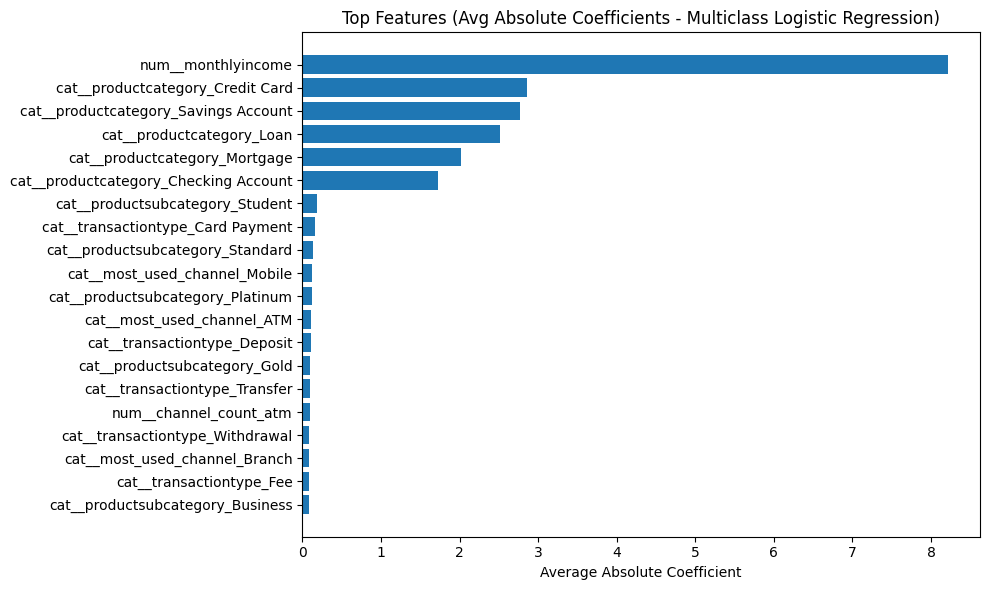


Top features for class 0:
num__monthlyincome: 14.1195
cat__productcategory_Mortgage: 3.5357
cat__productcategory_Credit Card: 3.1518
cat__productcategory_Loan: -2.3241
cat__productcategory_Savings Account: -2.2373
cat__productcategory_Checking Account: -2.1784
cat__productsubcategory_Student: 0.3739
cat__most_used_channel_Mobile: 0.2665
cat__most_used_channel_Online: -0.2147
cat__transactiontype_Deposit: -0.1787


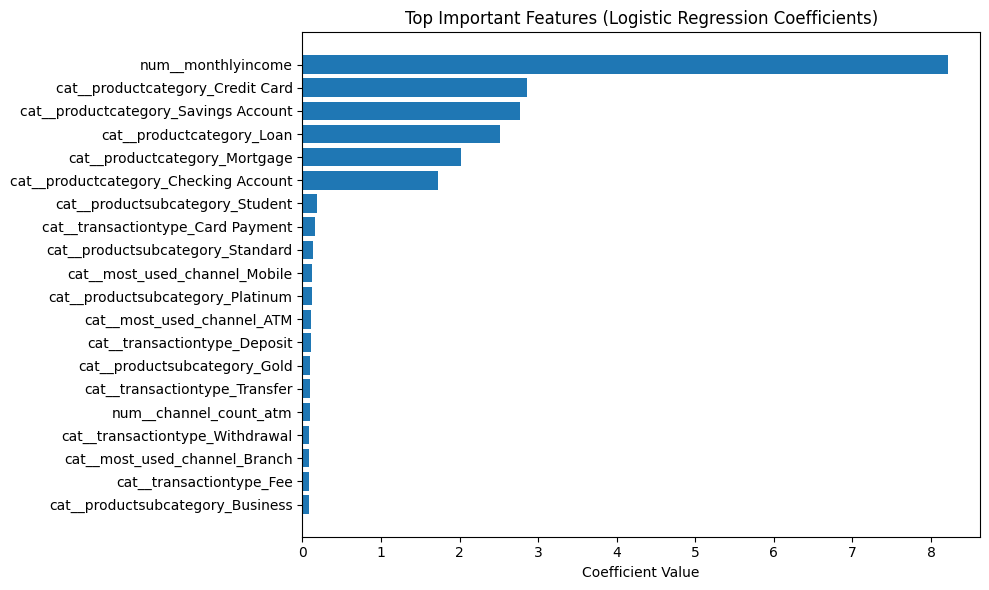


Top features for class 1:
num__monthlyincome: -16.2111
cat__productcategory_Savings Account: -5.3156
cat__productcategory_Credit Card: 1.3829
cat__productcategory_Checking Account: 1.2954
cat__productcategory_Loan: 1.1706
cat__productcategory_Mortgage: 1.1499
cat__transactiontype_Withdrawal: -0.1876
cat__most_used_channel_ATM: -0.1757
cat__productsubcategory_Standard: -0.1713
cat__productsubcategory_Student: -0.1677


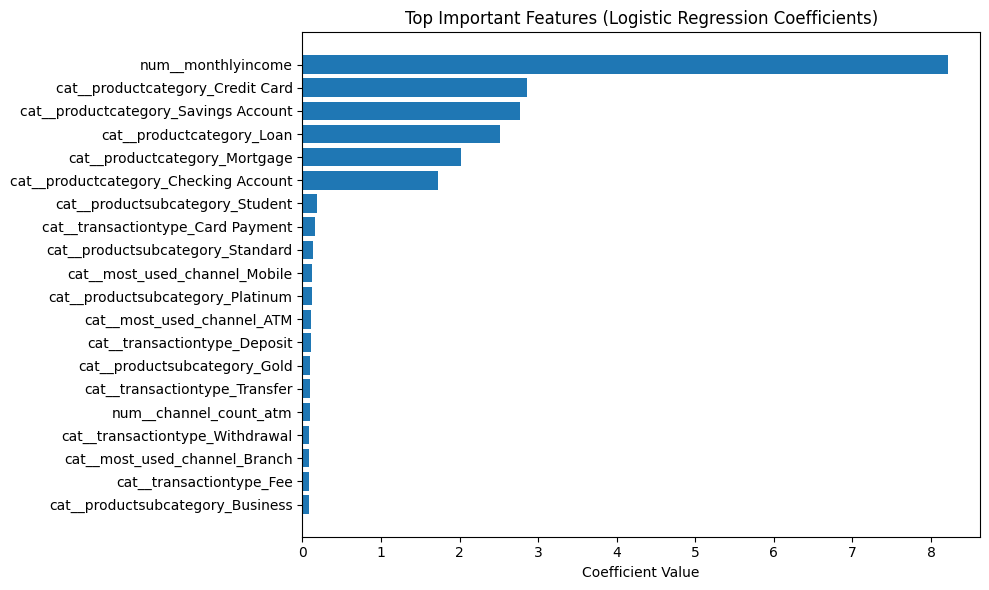


Top features for class 2:
cat__productcategory_Credit Card: 5.4885
cat__productcategory_Loan: -1.6437
cat__productcategory_Mortgage: -1.3575
cat__productcategory_Checking Account: -1.2903
cat__productcategory_Savings Account: -0.9774
num__monthlyincome: -0.2568
cat__most_used_channel_Online: 0.1929
cat__productsubcategory_Gold: 0.1695
cat__transactiontype_Card Payment: -0.1629
cat__transactiontype_Deposit: 0.1621


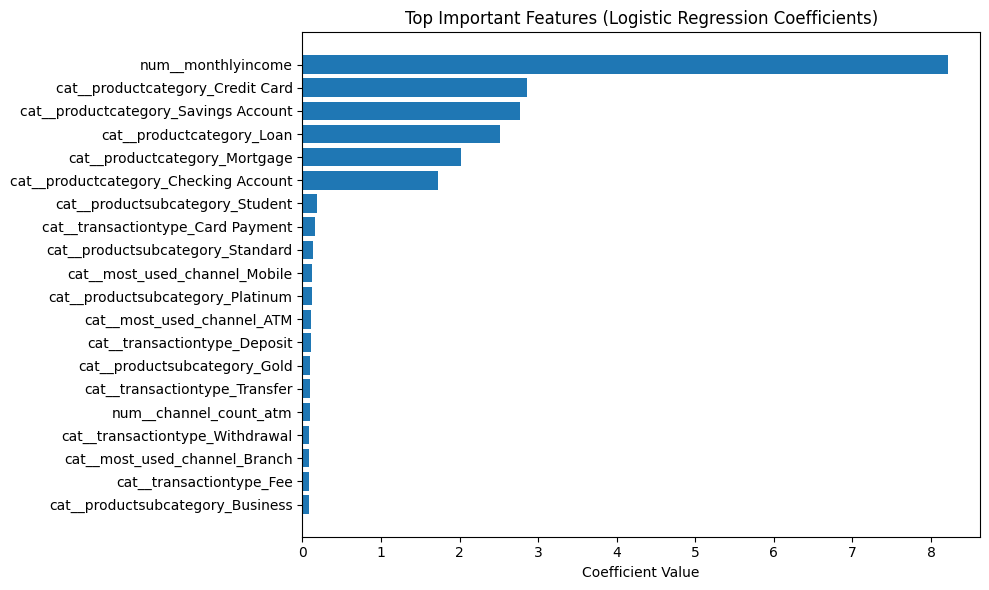


Top features for class 3:
cat__productcategory_Credit Card: -3.6269
cat__productcategory_Loan: -3.5792
cat__productcategory_Savings Account: 2.5267
cat__productcategory_Checking Account: 2.3935
cat__productcategory_Mortgage: 2.3726
num__monthlyincome: 0.3061
cat__most_used_channel_Branch: -0.1378
cat__most_used_channel_Mobile: 0.1226
cat__most_used_channel_ATM: 0.1079
cat__productsubcategory_Standard: 0.0822


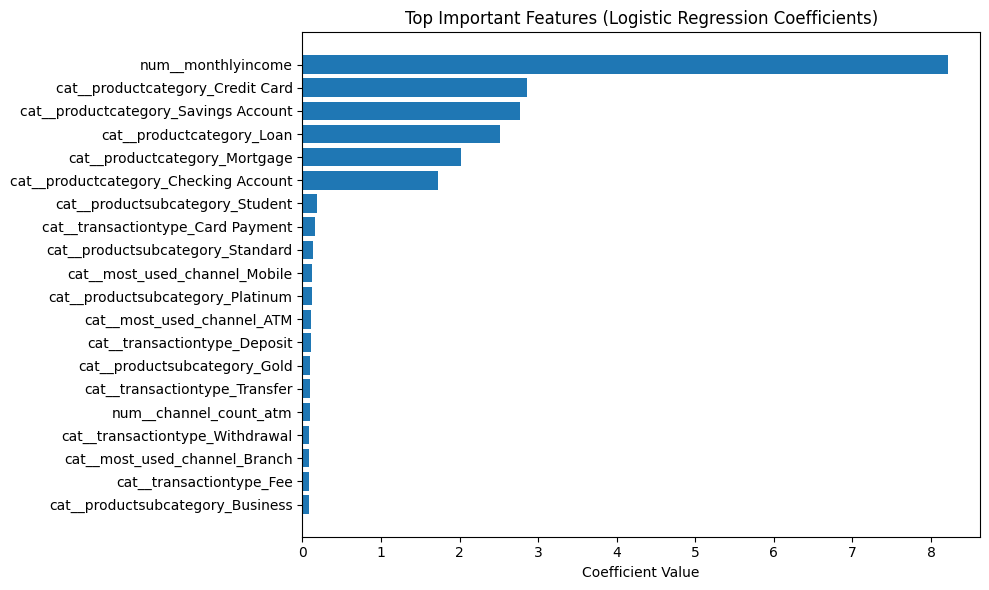


Top features for class 4:
num__monthlyincome: -12.2777
cat__productcategory_Savings Account: 4.7995
cat__productcategory_Loan: -1.2788
cat__productcategory_Mortgage: -1.2423
cat__productcategory_Checking Account: -1.2326
cat__productcategory_Credit Card: -1.2016
cat__productsubcategory_Student: -0.4455
cat__productsubcategory_Platinum: 0.3900
cat__transactiontype_Card Payment: -0.3574
cat__productsubcategory_Standard: -0.2716


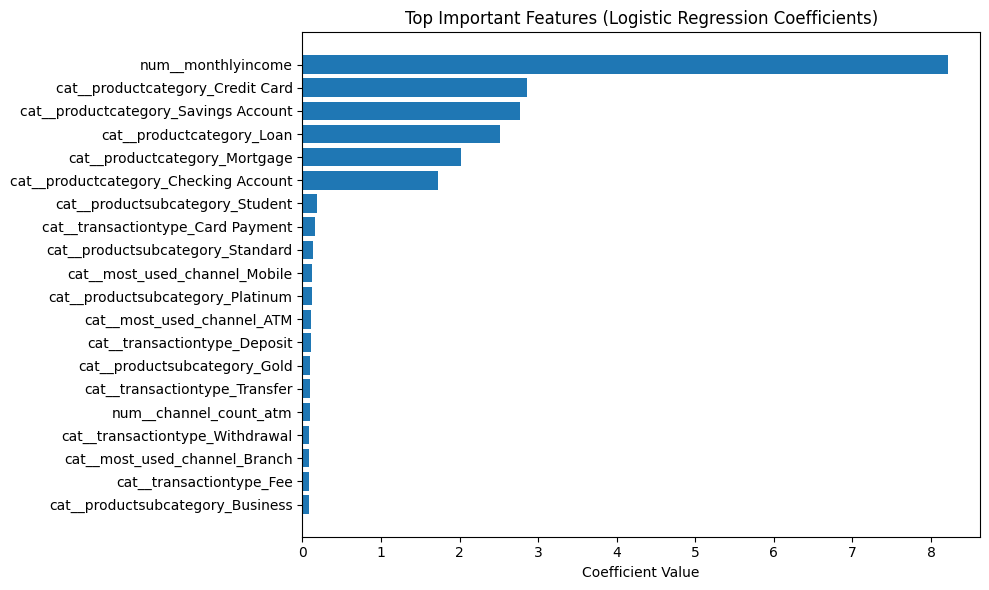


Top features for class 5:
cat__productcategory_Loan: 5.5442
cat__productcategory_Credit Card: -1.6775
cat__productcategory_Checking Account: -1.3509
cat__productcategory_Savings Account: -1.1704
cat__productcategory_Mortgage: -1.1628
cat__productsubcategory_Standard: 0.1727
cat__transactiontype_Card Payment: 0.1717
cat__most_used_channel_Branch: 0.1378
cat__transactiontype_Fee: 0.1270
cat__transactiontype_Transfer: -0.1234


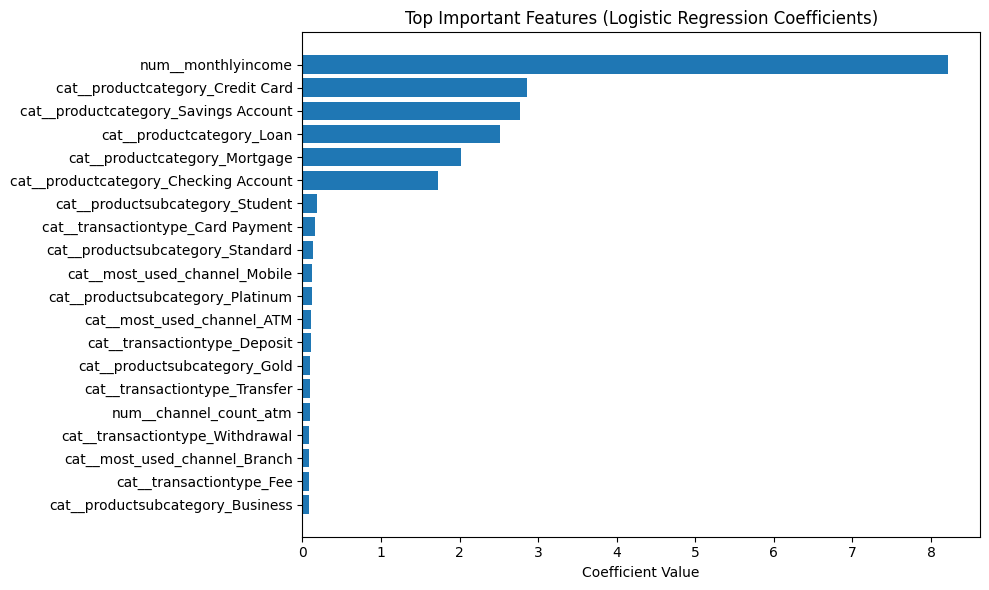


Top features for class 6:
num__monthlyincome: 14.3113
cat__productcategory_Credit Card: -3.5172
cat__productcategory_Mortgage: -3.2956
cat__productcategory_Savings Account: 2.3744
cat__productcategory_Checking Account: 2.3633
cat__productcategory_Loan: 2.1109
cat__transactiontype_Card Payment: 0.2475
cat__productsubcategory_Gold: -0.2336
cat__transactiontype_Transfer: -0.2263
cat__transactiontype_Deposit: 0.1778


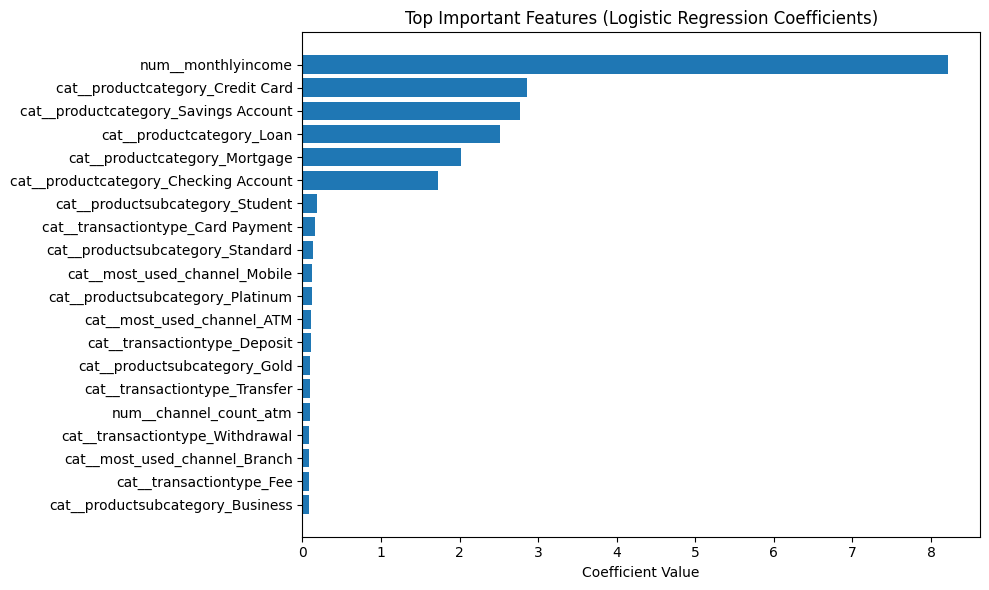

[2025-06-09 21:32:07,283: INFO: 1922399132: Saving the trained model]
Model directory: artifacts\model_training
Directory exists? True
Is a directory? True
Model path: artifacts\model_training\random.joblib
Model will be saved to: artifacts\model_training\random.joblib
[2025-06-09 21:32:07,303: INFO: 1922399132: Model training completed successfully]


In [220]:
try:
    config = ConfigurationManager()
    model_training_config = config.get_model_training_config()
    model_trainer = ModelTraining(config=model_training_config)
    model_trainer.train()
except Exception as e:
    logger.exception(f"An error occurred during model training: {e}")
    